135 개 Meter, 5 개 DCU에 대해 20191206 ~ 20200802 기간의 미터별 일별 사용량 특징 데이터셋 (241일) - cs_daily_features
IQR 기반 전력사용 이상 미터 - meter_id_list_iqr

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
%matplotlib inline

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
meter_id_list = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/meter_id_list_iqr")
meter_id_list_iqr = [ row["LP_METER_ID"] for row in meter_id_list.collect() ]

In [2]:
# Spark Dataframe to Pandas Dataframe
df = data.toPandas()

# IQR NTL Meter Index
anomaly = df.loc[ df.LP_METER_ID.isin(meter_id_list_iqr) ]
anomaly_index_iqr = list(anomaly.index)
anomaly_index_iqr

[5, 14, 15, 31, 34, 79, 80, 91, 95, 100, 105, 116, 126, 132]

In [3]:
# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

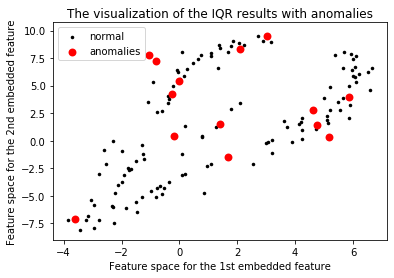

In [4]:
# t-SNE 비선형 임베딩 알고리즘을 사용하여 (241 개 사용량  + 5 개 DCU)의 246 -dim to 2-dim
tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 데이터 포인트 플롯
plt.scatter(df_reduce[:135, 0], df_reduce[:135, 1], marker='.', s=50, lw=0, alpha=1,
            c="black", edgecolor='k', label="normal")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_iqr, 0], df_reduce[anomaly_index_iqr, 1], marker='.', s=250, lw=0, alpha=1,
            c="red", edgecolor='k', label="anomalies")

plt.title("The visualization of the IQR results with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
#plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
plt.legend()
plt.show()